# Fitting a poisson Hidden Markov Model on spiking data 
#### The goal of this notebook is to provide an example how one would go about using a state space model to say something about underyling dynamics in study. Fitting the model is the "easy" part. Interpreting it is where the work really begins. Lia Papadopoulos kindly provided simulated data from 2 clustered spiking neural network simulations - described in Wyrick & Mazzucato, 2021. One being the 'base' condition, were all neurons receive the same external input and the other being the 'VarExtE' condition, where there is variability in the external input into the excitatory neurons. We know a'priori that the Var(E) condition creates faster switching between attractors, i.e. shorter cluster activations. Let's see if we can use a pHMM to determine this. 

####  Authors: David Wyrick, Luca Mazzucato, Lia Papadopoulos

In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, pdb
from glob import glob

#Base
import numpy as np
import pandas as pd
import scipy.stats as st
import multiprocessing

#Save
import json
import scipy.io as sio
import h5py

#Plot
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting-parameters
sns.set_style("ticks")
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'


#Model
import ssm
from ssm.plots import gradient_cmap, white_to_color_cmap

color_names=['windows blue','red','amber','faded green','dusty purple','orange','steel blue','pink',
             'greyish','mint','clay','light cyan','forest green','pastel purple','salmon','dark brown',
             'lavender','pale green','dark red','gold','dark teal','rust','fuchsia','pale orange',
             'cobalt blue','mahogany','cloudy blue','dark pastel green','dust','electric lime','fresh green','light eggplant']

from matplotlib.colors import LinearSegmentedColormap
def gradient_cmap(gcolors, nsteps=256, bounds=None):

    ncolors = len(gcolors)
    if bounds is None:
        bounds = np.linspace(0, 1, ncolors)

    reds = []
    greens = []
    blues = []
    alphas = []
    for b, c in zip(bounds, gcolors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1., 1.))

    cdict = {'red': tuple(reds),
             'green': tuple(greens),
             'blue': tuple(blues),
             'alpha': tuple(alphas)}

    cmap = LinearSegmentedColormap('grad_colormap', cdict, nsteps)
    return cmap

In [2]:
DataDir = './data/simulated'

network_ID = 5
#Read in simulated data of a spiking neural network arranged in E & I clusters, with 2 different 'conditions'
#One being the 'base' condition, were all neurons receive the same external input and the other
#being the 'VarExtE' condition, where there is variability in the external input into the excitatory neurons
#All of the simulated data is spontaneous activity; each file can be thought of as a recording of the same neurons with different initial conditions
file_list_base = sorted(glob(os.path.join(DataDir,'sweepNONE_base_network{}_*.mat'.format(network_ID))))
file_list_VarE = sorted(glob(os.path.join(DataDir,'sweepNONE_VarExtE_network{}_*.mat'.format(network_ID))))

#Model parameters
data = sio.loadmat(file_list_base[0],simplify_cells=True)
data['sim_params']

{'writeNetwork_to_file': 1,
 'writeSimulation_to_file': 1,
 'save_voltage': 0,
 'parameters_fileName': 'simulationData',
 'network_name': 'network',
 'load_network': 0,
 'randomize_ext_inputs': 0,
 'nu_ext_e_seed': 729,
 'nu_ext_i_seed': 587,
 'T0': 0.0,
 'TF': 6.0,
 'dt': 5e-05,
 'N': 2000,
 'ne': 0.8,
 'Vth_e': 1.43,
 'Vth_i': 0.74,
 'Vr_e': 0.0,
 'Vr_i': 0.0,
 'tau_m_e': 0.02,
 'tau_m_i': 0.02,
 'tau_s_e': 0.005,
 'tau_s_i': 0.005,
 'tau_r': 0.005,
 't_delay': 0.0,
 'pext': 0.2,
 'pee': 0.2,
 'pei': 0.5,
 'pii': 0.5,
 'pie': 0.5,
 'Jee': 0.014143129957686167,
 'Jie': 0.014143129957686167,
 'Jei': 0.0424293898730585,
 'Jii': 0.08485207154218452,
 'Jie_ext': 0.05176050154316513,
 'Jee_ext': 0.058095282123422035,
 'mean_nu_ext_e': 5.0,
 'mean_nu_ext_i': 5.0,
 'sig_nu_ext_e': 0.0,
 'sig_nu_ext_i': 0.0,
 'connType': 'fixed_InDegree',
 'p': 15,
 'bgrE': 0.1,
 'bgrI': 0.1,
 'clusters': array(['E', 'I'], dtype='<U1'),
 'clusterWeights': array(['EE', 'IE', 'II', 'EI'], dtype='<U2'),
 'Eclust

In [3]:
#The recordings we have right now are of 2000 neurons, arranged in clusters; to make our model fitting more efficient
#and to reduce model complexity (# of parameters), we're going to subselect neurons from each cluster and use those
clust_sizeE = data['clust_sizeE']
clust_sizeI = data['clust_sizeI']

#Select 5 random excitatory neurons from  each ext cluster to reduce size of "recording"
s_prev = 0; s_next = 0
indices = []
for s in clust_sizeE:
    s_next += s
    indices.append(np.random.choice(np.arange(s_prev,s_next),5,replace=False))
    s_prev = s_next

#Select 2 random inhibitory neurons frome each inh cluster
for s in clust_sizeI:
    s_next += s
    indices.append(np.random.choice(np.arange(s_prev,s_next),2,replace=False))
    s_prev = s_next

indices = np.concatenate(indices)


In [4]:
# Read data in and bin spikes into 50ms bins
# Each "recording" here will be an element of the list
spkt_list = []
data_list = []

for file in np.concatenate((file_list_base,file_list_VarE)):
    #Read in "trial"
    data = sio.loadmat(file,simplify_cells=True)
    
    #How long was the simulation run for
    tSim = data['sim_params']['TF'] - data['sim_params']['T0'] 

    #Bin size? 
    tBin = 50/1000

    #Bin the spikes
    nNeurons = int(data['sim_params']['N'])
    nBins = int(tSim/tBin)
    spk_counts = np.zeros((nNeurons,nBins),dtype=int)

    #Spike times 
    spktimes = data['spikes']
    nSpikes = spktimes.shape[-1]
    
    #For plotting raster plots later, let's grab just the subset of neurons we want
    tmp_list = [[] for i in range(len(indices))]
    for ii in range(nSpikes):
        iBin = int(np.floor(spktimes[0,ii]/tBin))
        iNeuron = int(spktimes[1,ii])
        if iBin < nBins:
            spk_counts[iNeuron,iBin] += 1
        
        if iNeuron in indices:
            jj = np.where(indices == iNeuron)[0][0]
            tmp_list[jj].append(spktimes[0,ii])
        
    #Take only subset of neurons and toss first second of simulation to avoid transient effects
    data_list.append(spk_counts[indices,:].T)
    spkt_list.append(tmp_list)

nT, nNeurons = data_list[0].shape

In [ ]:
##===== Exercise =====## 
#Let's first look at the data we're going to try and model; what can you see by eye? 
#the first 20 entries (recordings) in data_list contained simulations from the base network, while the last 20 entries contain simulations from the Var(E) network
network_type = np.concatenate((np.repeat('Base',20),np.repeat('VarExtE',20)))
#we can look at the data either by doing a "heatmap" of spike counts with imshow, or we can plot a raster with our spike times with eventplot



## Model selection
I've provided the code below just to show you how to do this; don't run cell because it takes quite a bit of computing power

In [ ]:
##===== Create function so we can parallelize =====##
def fit_ssm_get_llhood(training_data,test_data, num_states):
    N_iters = 1000
    nT, nNeurons = training_data[0].shape
    
    #Number of parameters for the model: (initial state distribution) + (transition matrix) + (mean values for each state) 
    num_parameters = num_states + num_states*num_states + num_states*nNeurons
    
    #Create HMM object to fit
    hmm = ssm.HMM(num_states, nNeurons, observations="poisson")

    #fit on training data
    hmm_lls = hmm.fit(training_data, method="em", num_iters=N_iters)#, init_method="kmeans")

    #Count total number of time steps in data
    nTrain = sum(map(len, training_data))
    nTest = sum(map(len, test_data))
    
    #Compute log-likelihood for each dataset
    ll_training = hmm.log_probability(training_data)/nTrain
    ll_heldout = hmm.log_probability(test_data)/nTest

    #Let's calculate the BIC as well for this
    BIC_heldout = num_parameters*np.log(nTest) - 2*hmm.log_probability(test_data)
    
    return ll_training, ll_heldout, BIC_heldout
    

In [ ]:
from sklearn.model_selection import StratifiedKFold

##===== K-fold Cross-Validation =====##
#There's no avoiding it! But I will do it for you; this cell is just to look at really

#Create kfold cross-validation object which will split data for us
nKfold = 5

#So 10-fold stratified cross-validation uses 90% of the data to train the model, and holds 10% for testing,
#ensuring equal proportions of data in the train and test sets of all the groups you want to stratify over
kf = StratifiedKFold(n_splits=nKfold, shuffle=True, random_state=None)    

#11 different nnumber of latent states
#10-fold cross-validation
#That's 110 model fits! Thankfully this can be parallelized fairly easily
Ks = np.arange(4,25,2)

ll_training = np.zeros((len(Ks),nKfold))
ll_heldout = np.zeros((len(Ks),nKfold))
BIC_heldout = np.zeros((len(Ks),nKfold))

# Creates parallel processes
pool = multiprocessing.Pool(processes=55)
    
process_outputs = []
#Outer loop over the parameter for which you're doing model selection for
for iS, num_states in enumerate(Ks):

    kfold_outputs = []
    #Inner loop over kfolds
    for ii, (train_index, test_index) in enumerate(kf.split(data_list,network_type)):        
        #Split data
        training_data = [data_list[ii] for ii in train_index]
        test_data = [data_list[ii] for ii in test_index]
        
        #Parallize process
        kfold_outputs.append(pool.apply_async(fit_ssm_get_llhood, args=(training_data, test_data, num_states)))
    process_outputs.append(kfold_outputs)

#Extract log_likelihood results from parallel kfold processing
for index, results in enumerate(process_outputs):
    ll_training[index,:] = np.array([iFold.get()[0] for iFold in results])
    ll_heldout[index,:] = np.array([iFold.get()[1] for iFold in results])
    BIC_heldout[index,:] = np.array([iFold.get()[2] for iFold in results])
        

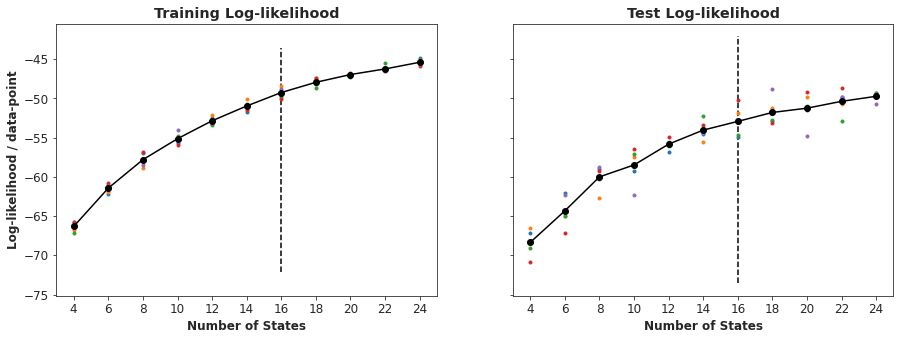

In [56]:
##===== Let's plot the heldout and training log-likelihoods and compare =====##
fig, axes = plt.subplots(1,2,figsize=(15,5),sharey=True)

#Training data
axes[0].plot(Ks,ll_training,'.')
axes[0].plot(Ks,np.mean(ll_training,axis=1),'-ok')
axes[0].set_title('Training Log-likelihood')
axes[0].set_ylabel('Log-likelihood / data-point')

axes[1].plot(Ks,ll_heldout,'.')
axes[1].plot(Ks,np.mean(ll_heldout,axis=1),'-ok')
axes[1].set_title('Test Log-likelihood')

for ax in axes:
    ax.set_xticks(Ks)
    ax.set_xlabel('Number of States')
    ax.vlines(16,*ax.get_ylim(),ls='--',color='k')


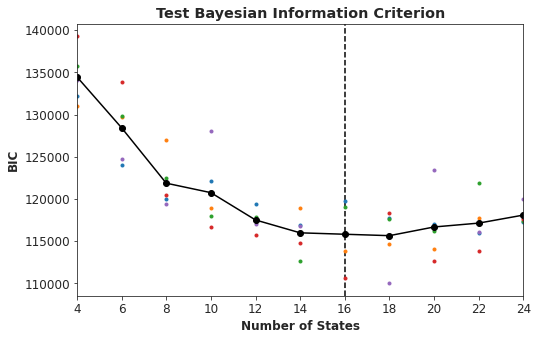

In [66]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Ks,BIC_heldout,'.')
ax.plot(Ks,np.mean(BIC_heldout,axis=1),'-ok')
ax.set_title('Test Bayesian Information Criterion')

ax.set_xticks(Ks)
ax.set_xlabel('Number of States')
ax.set_ylabel('BIC')
ax.vlines(16,*ax.get_ylim(),ls='--',color='k')
ax.autoscale(tight=True)


In [ ]:
# Let's fit a poisson HMM with 10 states just to see what we get. 
# If there's something interesting, then we will put the effort of doing cross-validation and finding the correct number of states to use
N_iters = 1000
nStates = 16    # number of discrete states determined by cross-validation
obs_dim = nNeurons # dimensionality of observation

#Make colormap for future plotting
cc = sns.xkcd_palette(color_names[:nStates])
cmap = gradient_cmap(cc)

##===== Exercise =====##
# Fit the pHMM to the data


In [68]:
##===== Exercise =====##
# Once the model has been fit, we can use the method expected_states of the hmm object to obtain the posterior probabilities p( state | data )
# Determine the maximum a posteriori estimation of the state sequence (MAPseq) 
# data = data_list[0]
# posterior_probabilities, expected_joints, log_likes = hmm.expected_states(data)
# Look at the posterior probabilities; what is the shape of it?



In [ ]:
##===== Exercise =====##
#Again plot a raster plot for an example recording for each network type along side it's corresponding MAP state sequence;
#to plot the state sequence, you can use the plt.imshow(MAP_list[iTrial][None], aspect="auto", cmap=cmap, vmin=0, vmax=nStates-1)
#Q: Is there a pattern for each state that reappears for each instance it occurs in the sequence? 
#Q: What are the main features of each state? 





In [ ]:
#Since we fit a poisson HMM, let's look at the model parameters that defined a poisson process, lambda
mean_firing_rates = np.exp(hmm.observations.log_lambdas)

#And the transition probability matrix; W
TPM = hmm.transitions.transition_matrix

##===== Exercise =====##
# Plot the mean firing rate vector for each state and compare with the state sequence overlaid on the data
# Plot the transition probability matrix? what do you notice about the matrix? Plot it 2 ways to look at off-diagonal elements


In [ ]:
# Now that we've looked at the HMM parameters, let's use the state sequences in both the base network simulation and Var(E) network sim to see if something pops out
# How do we do that? We can look at a few things, but let's start with state usage. 
##===== Exercise =====##
# Calculate the state usage - i.e. how often a state is used - conditioned on network type and plot; are states preferentially used depending on the conditon?
# Remember, the data_list, MAP_list, etc are organized: the first 20 elements of the lists are from the base network, while the last 20 are from the Var(E) network

state_usage = np.zeros((2,nStates)) #2 rows for the 2 conditions 



In [ ]:
# Now that we've identified that the state usage is different per condition, let's characterize these states
# We've already plotted the mean firing rate vectors which define the state, but now let's look at how long the states are active for 
# and how often they switch between states; This is called the state duration; and hopefully this will tell us something about the network dynamics we're studying.
##===== Exercise =====##
# Calculate the state duration distributions - i.e how long each state is used for across the recordings - conditioned on network type and plot; Are some states activated for longer periods of time than others?
# Sompthing simplier to calculate but just as informative is the mean state duration 

#Split data
MAP_list_base = [MAP_list[i] for i in range(20)]
MAP_list_VarE = [MAP_list[i] for i in range(20,40)]

mask_list_base = [mask_list[i] for i in range(20)]
mask_list_VarE = [mask_list[i] for i in range(20,40)]


## The End
### If you've made it this far and you weren't challenged, I apologize. I assure you, using state-space models on real data is where it get's tricky. If you have time, feel free to peruse the notebooks at https://github.com/lindermanlab/ssm to see all of the different flavors of state space models you can construct using this framework. The most success I've had is using ARHMMs on behavioral data to obtain "behavioral motifs" in an unsupervised way from Deep Lab Cut tracking data. Again, the fitting is kindly done for us behind the hood with SSM. The interpretation is where the hard work commes in. Congratulations on learning a bit about state space models and metastability. Now go use the tool on your own data! 